In [3]:
import pandas as pd
from numpy import *
import time

### 自定义函数实现AdaBoost
- 包含函数
    1. stumpClassify() 通过阈值对数据分类
    2. buildStump() 生成单层决策树，需要调用stumpClassify()
    3. adaBoostTrainDS() 训练出多个弱决策树分类器，需要调用buildStump() 
    4. adaClassify() 利用训练好的弱分类器分类数据
    5. loadDataSet() 加载数据集

#### 1. 构建单层决策树
- 遍历数据集的每个特征：
    - 遍历特征的每个步长：
        - 遍历步长的每个阈值对比方式：
            - 计算每次迭代的weightedError
- 认为weightedError最小的点(特征，阈值，方式)是最佳决策点，以此构建一棵决策树桩(stump)

In [4]:
#通过阈值对数据分类+1 -1
#dimen为dataMat的列索引值，即特征位置；threshIneq为阈值对比方式，大于或小于
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray=ones((shape(dataMatrix)[0],1))#注意，有两个()
    #阈值的模式，将小于某一阈值的特征归类为-1
    if threshIneq=='lt':#less than
        retArray[dataMatrix[:,dimen]<=threshVal]=-1.0
    #将大于某一阈值的特征归类为-1
    else:#greater than
        retArray[dataMatrix[:,dimen]>threshVal]=-1.0
    return retArray

#单层决策树生成函数
#D为各样本权重,shape=(m,1);label为样本标签，shape=(1,m)
def buildStump(dataArr,classLabels,D):
#将数据集和标签列表转为矩阵形式
    dataMatrix=mat(dataArr);labelMat=mat(classLabels).T
    m,n=shape(dataMatrix)
    #步长或区间总数 最优决策树信息 最优单层决策树预测结果
    numSteps=10.0;bestStump={};bestClasEst=mat(zeros((m,1))) #注意，有两个()
    #最小错误率初始化为+∞
    minError=inf
    
    #遍历数据集的每个特征：遍历特征的每个步长：遍历步长的每个阈值对比方式
    for i in range(n):
        #找出列中特征值的最小值和最大值
        rangeMin=dataMatrix[:,i].min();rangeMax=dataMatrix[:,i].max()
        #求取步长大小或者说区间间隔
        stepSize=(rangeMax-rangeMin)/numSteps
        #遍历各个步长区间
        for j in range(-1,int(numSteps)+1):
            #两种阈值过滤模式
            for inequal in ['lt','gt']:
                threshVal=rangeMin+float(j)*stepSize
                #选定阈值后，调用阈值过滤函数分类预测
                predictedVals=\
                    stumpClassify(dataMatrix,i,threshVal,inequal)
                #初始化错误向量
                errArr=mat(ones((m,1)))
                #将错误向量中分类正确项置0
                errArr[predictedVals==labelMat]=0
                #计算"加权"的错误率
                weigthedError=D.T*errArr
                #print ("分割特征为第{0}个，分割阈值为{1}，分割方式为{2}，weight error为{3}"\
                #      .format(i+1,threshVal,threshIneq,weightedErr))
                if weigthedError<minError:
                    minError=weigthedError
                    bestClasEst=predictedVals.copy()
                    bestStump['dim']=i
                    bestStump['thresh']=threshVal
                    bestStump['ineq']=inequal
    #返回最佳单层决策树相关信息的字典，最小错误率，决策树预测输出结果
    return bestStump,minError,bestClasEst

In [5]:
data=mat([[ 1. ,  2.1],[ 2. ,  1.1],[ 1.3,  1. ],[ 1. ,  1. ],[ 2. ,  1. ]])
label=[1.0,1.0,-1.0,-1.0,1.0];D=mat(ones((5,1))/5)
buildStump(array(data),array(label),D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

#### 2. AdaBoost提升单层决策树效果
- 样本初始权重D=1/m
- 进入循环：(设置循环次数上限or错误率e=0为止)
    - 将D带入buildStump，训练最佳决策树，得到本次迭代的最佳分类bestClass
    - 计算汇集的分类结果aggClass(即，将每次最佳决策树分类结果bestClass\*alpha相加)
    - 根据当前的汇集分类错误率e，计算alpha，并更新样本权值D
    - 直到达到循环次数上限或错误率e=0为止
- 输出弱分类器集合(bestStump的集合)

In [6]:
#label为样本标签，shape=(1,m)
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr=[];m=shape(dataArr)[0]
    D=mat(ones((m,1))/m) #初始化样本权重
    aggClassEst=mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst=buildStump(dataArr,classLabels,D)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16))) #max(error,1e-16)防止0误差的计算溢出
        bestStump["alpha"]=alpha
        weakClassArr.append(bestStump)
        #print ("D:",D.T,"\n","predClass:",classEst.T)
        
        #为下一次迭代更新D(很关键，矩阵运算容易写错！)
        expon=multiply(-1*alpha*mat(classLabels).T,classEst) #shape(5,1)*shape(5,1)对应元素相乘，得到各样本的-alpha*yi*G(xi)
        D=multiply(D,exp(expon)) #shape(5,1)*shape(5,1)对应元素相乘，
        D=D/D.sum() #得到各样本更新后的wi
        
        #计算汇集的分类结果aggClassEst(即，将每次最佳决策树分类结果bestClass*alpha相加)
        aggClassEst+=alpha*classEst
        #print("aggClassEst:",aggClassEst.T)
        aggErrors=multiply(sign(aggClassEst)!=mat(classLabels).T,ones((m,1)))
        errorRate=aggErrors.sum()/m
        #print("total error:",errorRate)
        if errorRate==0.0:
            break
    return weakClassArr,errorRate,aggClassEst

In [12]:
data=mat([[ 1. ,  2.1],[ 2. ,  1.1],[ 1.3,  1. ],[ 1. ,  1. ],[ 2. ,  1. ]])
label=[1.0,1.0,-1.0,-1.0,1.0];D=mat(ones((5,1))/5)
adaBoostTrainDS(array(data),array(label))

([{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
  {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
  {'alpha': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.9}],
 0.0)

#### 3. 使用adaboost+单层决策树模型分类数据

In [7]:
def adaClassify(datToClass,classifierArr):
    dataMatrix=mat(datToClass)
    m=shape(dataMatrix)[0]
    aggClassEst=mat(zeros((m,1))) #初始化最终分类器
    for i in range(len(classifierArr)):#遍历各个弱分类器
        #每一个弱分类器对测试数据进行预测分类
        classEst=stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                classifierArr[i]['thresh'],
                                classifierArr[i]['ineq'])
        #对各个分类器的预测结果进行加权累加
        aggClassEst+=classifierArr[i]['alpha']*classEst
        #print('aggClassEst',aggClassEst)
    #通过sign函数根据结果大于或小于0预测出+1或-1
    return sign(aggClassEst)

In [9]:
#训练集，特征和标签
data=[[ 1. ,  2.1],[ 2. ,  1.1],[ 1.3,  1. ],[ 1. ,  1. ],[ 2. ,  1. ]]
label=[1.0,1.0,-1.0,-1.0,1.0];D=mat(ones((5,1))/5)

#训练弱分类器，得到各个弱分类器的最优分类特征、阈值、方式、alpha、bestClass
weakClassifierArr,trainErrorRate,aggClassEst=adaBoostTrainDS(array(data),array(label))
print('\n')
#用训练好的弱分类器预测测试集样本类别
adaClassify([[0,0]],weakClassifierArr)

matrix([[-1.]])

### 使用自定义AdaBoost预测疝病马是否存活
- 读取数据、处理数据
- 使用adaBoostTrainDS训练弱分类器
- 使用adaClassify预测疝病马是否存活

In [10]:
#加载数据函数
def loadDataSet(filename):
    dataMat=[];labelMat=[]
    numFeat=len(open(filename).readline().split('\t'))
    fr=open(filename)
    for line in fr.readlines():
        lineArr=[]
        curLine=line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [11]:
#加载数据
dataArr,labelArr=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTraining2.txt')
shape(dataArr),shape(labelArr)

((299, 21), (299,))

In [13]:
#训练弱分类器
classifierArr,trainErrorRate,aggClassEst=adaBoostTrainDS(dataArr,labelArr,10)

In [14]:
#用训练好的弱分类器分类测试样本
dataTest,labelTest=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTest2.txt')
predictLabels=adaClassify(dataTest,classifierArr)

In [15]:
#计算分类准确率
errArr=mat(ones((len(labelTest),1)))
errArr[predictLabels==mat(labelTest).T]=0
errorRate=errArr.sum()/len(labelTest)
print("测试集分类错误率为{0}%".format(round(errorRate*100),2))

测试集分类错误率为24.0%


In [18]:
def horseColic(numWeakClassifier):
    #读取训练集、测试集
    dataArr,labelArr=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTraining2.txt')
    dataTest,labelTest=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTest2.txt')
    #训练弱分类器
    classifierArr,trainErrorRate,aggClassEst=adaBoostTrainDS(dataArr,labelArr,numWeakClassifier)
    #用训练好的弱分类器分类测试样本
    predictLabels=adaClassify(dataTest,classifierArr)
    #计算分类准确率
    errArr=mat(ones((len(labelTest),1)))
    errArr[predictLabels==mat(labelTest).T]=0
    testErrorRate=errArr.sum()/len(labelTest)
    return numWeakClassifier,trainErrorRate,testErrorRate

In [19]:
for i in [1,10,100,500,1000]:
    numWeakClassifier,trainErrorRate,testErrorRate=horseColic(i)
    print("=".center(70,"="))
    print("弱分类器个数为{0}时，训练集分类错误率为{1}%，测试集分类错误率为{2}%"\
          .format(i,round(trainErrorRate*100,2),round(testErrorRate*100,2)))
print("=".center(70,"="))

弱分类器个数为1时，训练集分类错误率为28.43%，测试集分类错误率为26.87%
弱分类器个数为10时，训练集分类错误率为23.08%，测试集分类错误率为23.88%
弱分类器个数为100时，训练集分类错误率为19.06%，测试集分类错误率为22.39%
弱分类器个数为500时，训练集分类错误率为15.72%，测试集分类错误率为25.37%
弱分类器个数为1000时，训练集分类错误率为14.05%，测试集分类错误率为31.34%


- **分析**
    - 并不是弱分类器越多越好，太多容易过拟合，使得测试集准确率较低，太少容易欠拟合，使得训练集准确率较低，**因此adaboost的弱分类器个数是一个需要斟酌的参数**

### 绘制ROC曲线衡量分类性能

In [20]:
#aggClassEst为每次训练累加的预测值，是sign()之前的值，表示预测强度,array格式,shape=(m,1)
#classLabels是样本真实类别,array格式,shape=(m,1)
def plotROC(aggClassEst,classLabels):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    cur=(1.0,1.0) #初始光标，从(1,1)开始，表示假设样本全被预测为正
    ySum=0.0 #用于计算AUC，X轴每移动一步，ySum就加一次当时的y值，相当于计算曲线下矩形面积
    numPosClass=sum(classLabels==1.0) #真实类别为1的样本数
    yStep=1/float(numPosClass) # ROC y轴表示真阳率(正例的召回率)
    xStep=1/float(len(classLabels)-numPosClass)# ROC x轴表示假阳率(真阴率，反例的召回率)
    sortedIndex=argsort(aggClassEst.T) #返回aggClassEst中元素升序排序时各元素所对应的索引值
    
    fig=plt.figure(figsize=(8,8))
    fig.clf() #clear画布
    ax=plt.subplot(111)
    
    """
    按升序遍历aggClassEst(累加预测值)，每次循环中，认为当前aggClassEst[index]是分类阈值
    <=阈值时，认为是-1.0类；>阈值时认为是+1.0类
    将该阈值样本的假设类别-1.0与该阈值样本的真实类别classLabels[index]对比
    若真实类别为1.0,则拉低真阳率(漏报率)；若真实类别为-1.0,则拉低假阳率(误报率)
    """
    for index in sortedIndex.tolist()[0]:
        #若判别为最小的样本真实为正例(说明正例被错判,FN)，则减小Y值(TP/(TP+FN))
        if classLabels[index]==1.0: 
            delX=0.0;delY=yStep
        #若判别为最小的样本真实为反例(说明反例被对判,TN)，则减小X值(FP/(FP+TN))
        else:
            delX=xStep;delY=0.0
            ySum+=cur[1] #x每移动一个xStep，ySum就叠加一个当时的y值，用于计算曲线下矩形面积
        
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='r') #绘制ROC曲线
        cur=(cur[0]-delX,cur[1]-delY) #更新光标位置
        
    ax.plot([0,1],[0,1],'b--') #[0,1],[0,1]表示x,y值的一一对应关系,即(0,0)(1,1)两个点,并用线连接起来
    plt.xlabel("假阳率",fontsize=16,fontweight="bold")
    plt.ylabel("真阳率",fontsize=16,fontweight="bold")
    plt.title("AdaBoost疝病马预测ROC曲线",fontsize=20,fontweight="bold")
    ax.axis([0,1,0,1])
    plt.show()
    print("ROC曲线的AUC为:",ySum*xStep)

In [21]:
dataArr,labelArr=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTraining2.txt')
classifierArr,trainErrorRate,aggClassEst=adaBoostTrainDS(dataArr,labelArr,50)

In [59]:
argsort(aggClassEst.T).tolist()[0]

[176,
 35,
 40,
 192,
 272,
 49,
 101,
 16,
 83,
 181,
 225,
 44,
 230,
 172,
 256,
 170,
 59,
 179,
 97,
 168,
 227,
 244,
 285,
 296,
 150,
 239,
 141,
 295,
 121,
 45,
 291,
 46,
 173,
 43,
 234,
 73,
 245,
 246,
 210,
 86,
 30,
 134,
 159,
 48,
 290,
 109,
 113,
 133,
 178,
 204,
 128,
 108,
 280,
 219,
 99,
 110,
 281,
 80,
 58,
 252,
 8,
 292,
 171,
 200,
 253,
 229,
 262,
 123,
 15,
 64,
 273,
 249,
 36,
 261,
 62,
 203,
 151,
 207,
 216,
 0,
 54,
 91,
 184,
 140,
 75,
 177,
 221,
 70,
 135,
 78,
 104,
 209,
 57,
 72,
 271,
 34,
 3,
 117,
 195,
 297,
 4,
 19,
 294,
 241,
 10,
 242,
 162,
 270,
 147,
 238,
 143,
 31,
 55,
 93,
 126,
 237,
 247,
 37,
 254,
 286,
 84,
 68,
 282,
 18,
 63,
 164,
 287,
 174,
 28,
 186,
 278,
 39,
 218,
 167,
 25,
 258,
 74,
 196,
 263,
 274,
 26,
 232,
 251,
 131,
 20,
 56,
 118,
 188,
 79,
 13,
 226,
 66,
 114,
 17,
 215,
 124,
 24,
 41,
 190,
 160,
 206,
 156,
 130,
 265,
 51,
 82,
 250,
 266,
 1,
 268,
 154,
 65,
 201,
 298,
 42,
 269,
 205,
 193,

In [44]:
shape(aggClassEst),shape(mat(labelArr).T)

((299, 1), (299, 1))

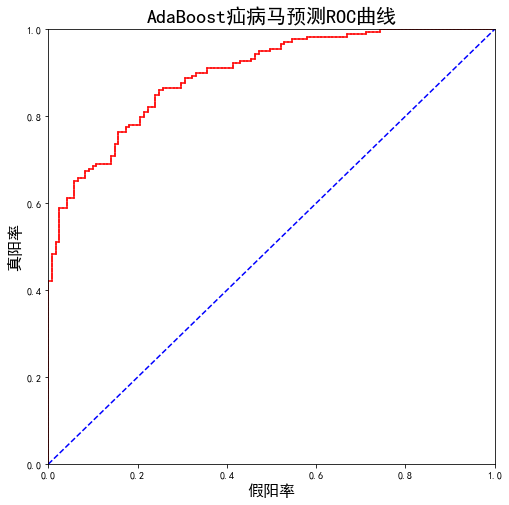

ROC曲线的AUC为: 0.8953941870182941


In [63]:
plotROC(aggClassEst,mat(labelArr).T)

### sklearn实现AdaBoost，用于疝病马数据集

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [27]:
dataArr,labelArr=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTraining2.txt')
dataTest,labelTest=loadDataSet(r'D:\DM\python\data\MLiA_SourceCode\machinelearninginaction\Ch07\horseColicTest2.txt')
abc=AdaBoostClassifier(n_estimators=50)

In [28]:
#训练弱分类器
abc.fit(dataArr,labelArr)
Y_pred=abc.predict(dataTest)
abc.score(dataTest,labelTest)

0.7761194029850746

In [33]:
#返回模型属性
print (abc.classes_) #返回类别标签
print (abc.estimator_weights_ ) #返回训练得到的各分类器权重 alpham
print (abc.estimator_errors_)  #返回训练得到的各分类器分类误差
#print (abc.estimators_) #返回训练得到的弱分类器，列表格式

[-1.  1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0.28428094 0.33214454 0.39257738 0.40697642 0.41930599 0.40339763
 0.4357326  0.42456092 0.44568626 0.42683673 0.45293997 0.45518735
 0.4225583  0.43627423 0.43044037 0.42723727 0.4744538  0.431832
 0.44713836 0.44962627 0.46277843 0.43343921 0.43638023 0.47462149
 0.45972328 0.46639559 0.43662019 0.42964436 0.43240759 0.44019402
 0.48131686 0.48714723 0.47491754 0.45261708 0.45541079 0.45172395
 0.44629907 0.4741625  0.47014168 0.45891498 0.44262397 0.48395967
 0.4574864  0.45985565 0.45594619 0.45687237 0.45398568 0.46546841
 0.47404671 0.45379753]
